UPTAKE REGR

In [4]:
df4

,sequence,extra_name,cpp_category,is_cpp,cpp_type,origin,id_uptake,peptide,uptake_type,raw_efficiency,...,Positive_AA,Negative_AA,MolWt,LogP,TPSA,HBD,HBA,RotBonds,Rings,Fsp3
id,,,,,,,,,,,,,,,,,,,,,
2721,(Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK,NaN,NaN,True,NaN,NaN,938.0,2721.0,Fluorescence intensity,750,...,13,0,3106.855,-10.12793,1242.72,45,44,120,5,0.610738
2724,(Acp)-RKRRQTSMTDFYHSKRRLIFS,NaN,NaN,True,NaN,NaN,969.0,2724.0,Fluorescence intensity,1400,...,8,1,2740.203,-13.31615,1220.16,47,39,95,4,0.583333
2630,?A-RR-[KRRRRRE],NaN,NaN,True,NaN,NaN,720.0,2630.0,Relative Mean Fluorescence intensity (%),75,...,8,1,1423.708,-10.26761,801.61,33,20,54,0,0.678571
2629,?A-RRR-[KRRRRE],NaN,NaN,True,NaN,NaN,719.0,2629.0,Relative Mean Fluorescence intensity (%),95,...,8,1,1423.708,-10.26761,801.61,33,20,54,0,0.678571
2628,?A-RRRR-[KRRRE],NaN,NaN,True,NaN,NaN,718.0,2628.0,Relative Mean Fluorescence intensity (%),66,...,8,1,1423.708,-10.26761,801.61,33,20,54,0,0.678571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317,rRrGrKkRr,cTAT-GFP,NaN,True,NaN,NaN,525.0,2317.0,Cellular uptake (%),80.0,...,3,0,1268.551,-9.25428,719.56,30,18,49,0,0.700000
2324,rrrrrrrrrrrrGC,r12,NaN,True,NaN,NaN,621.0,2324.0,Relative fluorescence (%),424.0,...,0,0,2052.481,-16.57886,1184.42,52,28,76,0,0.662338
3022,stearly-His6-HHHHHHHHHHHHHHHH–NH2,NaN,NaN,True,NaN,NaN,1802.0,3022.0,Relative cellular uptake (%),100,...,18,0,5543.962,-26.48033,2379.26,84,83,172,25,0.475207


IMPOTTANCE FROM RF

Mean Absolute Error: 335.6045


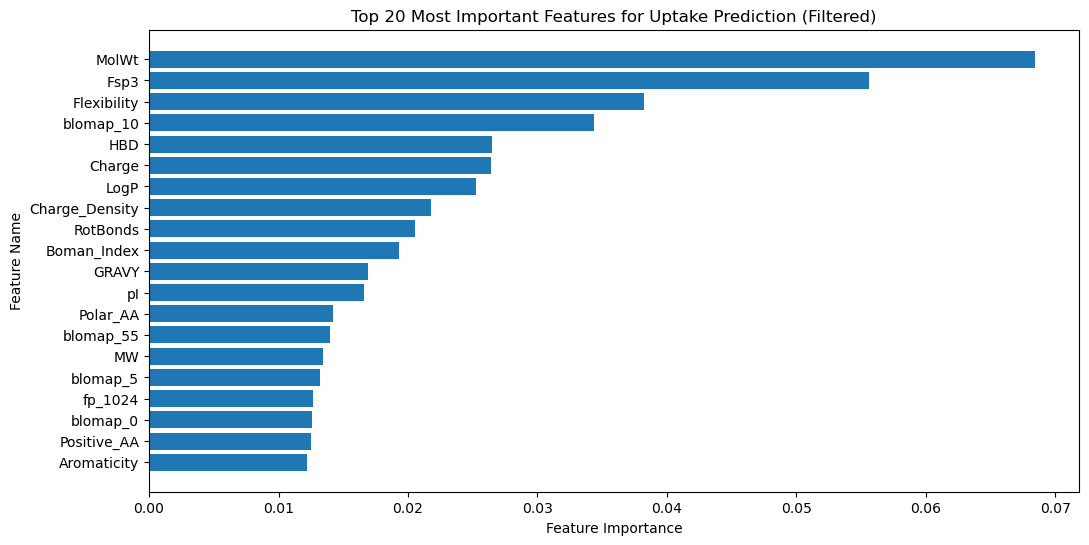

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Select only meaningful features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract only the selected features
X_numerical = df4[selected_features]

# Combine all features (numerical descriptors + embeddings)
X = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === 4. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 5. Train Random Forest Regressor ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === 6. Evaluate model ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# === 7. Feature Importance ===
feature_importances = model.feature_importances_

# Get feature names
num_features = X_numerical.shape[1]
feature_names = selected_features + \
                [f"blomap_{i}" for i in range(blomap_embeddings.shape[1])] + \
                [f"fp_{i}" for i in range(fingerprints_embeddings.shape[1])] + \
                [f"protbert_{i}" for i in range(protbert_embeddings.shape[1])]

# Sort importances
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# === 8. Plot Feature Importance ===
plt.figure(figsize=(12, 6))
plt.barh(sorted_features[:20], sorted_importances[:20])  # Top 20 features
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features for Uptake Prediction (Filtered)")
plt.gca().invert_yaxis()
plt.show()

In [8]:
print("Shape of numerical features:", X_numerical.shape)
print("Shape of blomap embeddings:", blomap_embeddings.shape)
print("Shape of fingerprints:", fingerprints_embeddings.shape)
print("Shape of protbert embeddings:", protbert_embeddings.shape)
print("Final shape of X:", X.shape)
print("Final shape of y:", y.shape)

Shape of numerical features: (877, 21)
Shape of blomap embeddings: (877, 1345)
Shape of fingerprints: (877, 2048)
Shape of protbert embeddings: (877, 1024)
Final shape of X: (877, 4438)
Final shape of y: (877,)


ABOUT UPTAKE

Descriptive Statistics for Uptake
count     877.000000
mean      858.465222
std       614.014833
min         2.000000
25%       279.000000
50%       724.000000
75%      1408.000000
max      1965.000000
dtype: float64


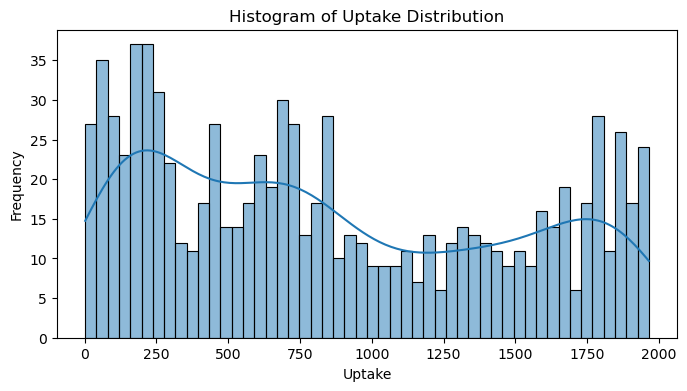

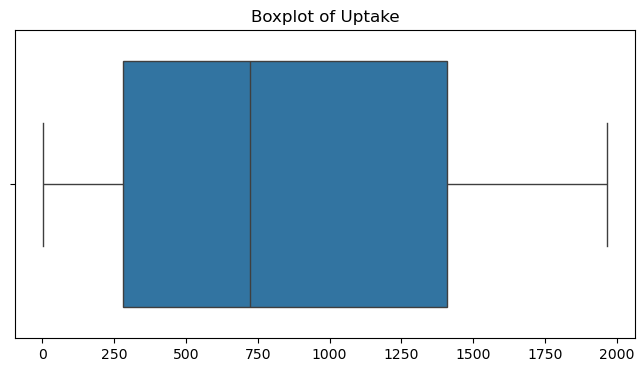

/var/folders/qh/n3ln1st96g91tlkklrwc8c480000gn/T/ipykernel_70501/221973152.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, label='Train', shade=True)
/var/folders/qh/n3ln1st96g91tlkklrwc8c480000gn/T/ipykernel_70501/221973152.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Test', shade=True)


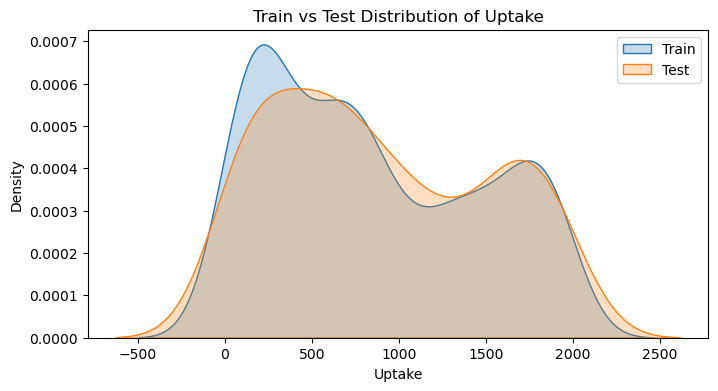

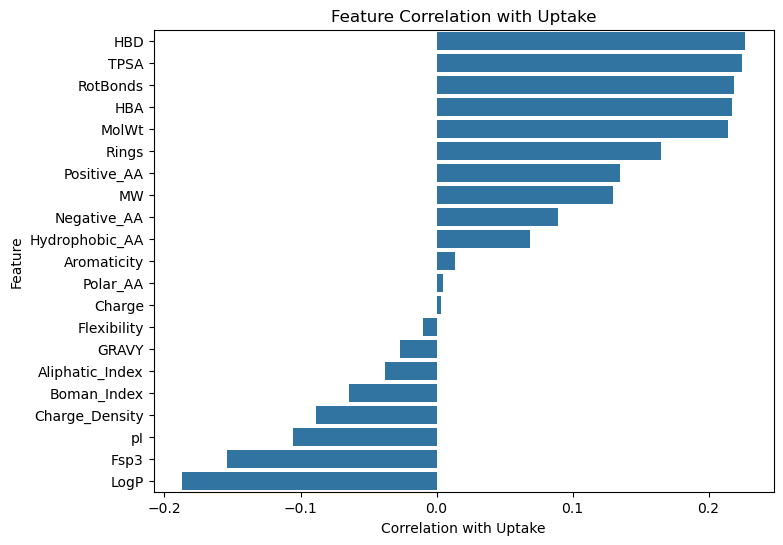

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


y_series = pd.Series(y)

# Описательная статистика
print("Descriptive Statistics for Uptake")
print(y_series.describe())

# 2. Гистограмма распределения uptake
plt.figure(figsize=(8, 4))
sns.histplot(y, bins=50, kde=True)
plt.xlabel("Uptake")
plt.ylabel("Frequency")
plt.title("Histogram of Uptake Distribution")
plt.show()

# 3. Boxplot для поиска выбросов
plt.figure(figsize=(8, 4))
sns.boxplot(x=y)
plt.title("Boxplot of Uptake")
plt.show()

# 4. Сравнение распределений Train/Test
plt.figure(figsize=(8, 4))
sns.kdeplot(y_train, label='Train', shade=True)
sns.kdeplot(y_test, label='Test', shade=True)
plt.xlabel("Uptake")
plt.ylabel("Density")
plt.title("Train vs Test Distribution of Uptake")
plt.legend()
plt.show()

# 5. Корреляция uptake с числовыми признаками
correlation_matrix = pd.DataFrame(X_numerical, columns=selected_features)
correlation_matrix['uptake'] = y
corrs = correlation_matrix.corr()['uptake'].drop('uptake').sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(y=corrs.index, x=corrs.values)
plt.xlabel("Correlation with Uptake")
plt.ylabel("Feature")
plt.title("Feature Correlation with Uptake")
plt.show()


log(y + 1) for uptake



Mean Absolute Error (original scale): 359.8933


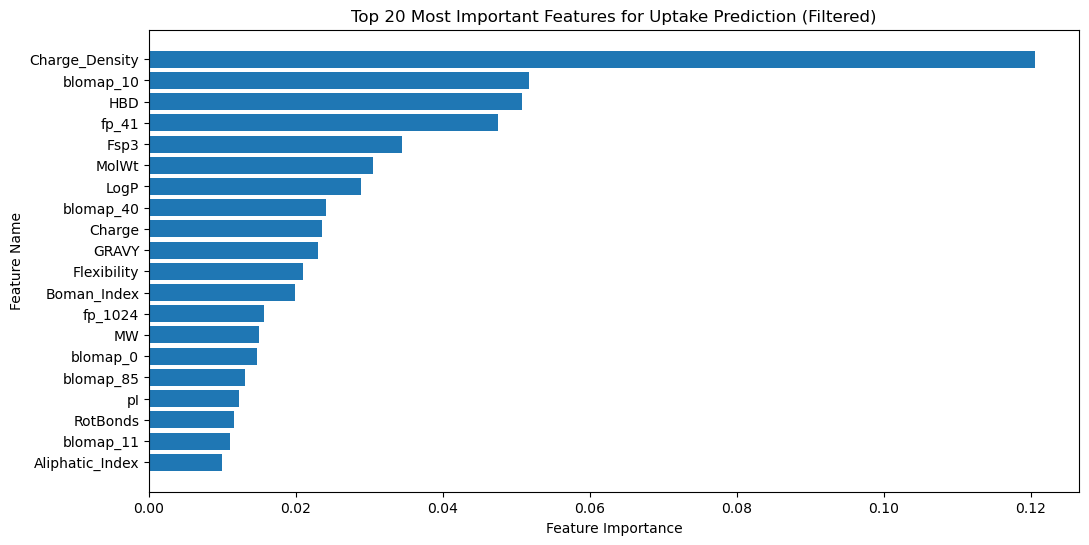

Descriptive Statistics for Uptake
count     877.000000
mean      858.465222
std       614.014833
min         2.000000
25%       279.000000
50%       724.000000
75%      1408.000000
max      1965.000000
dtype: float64


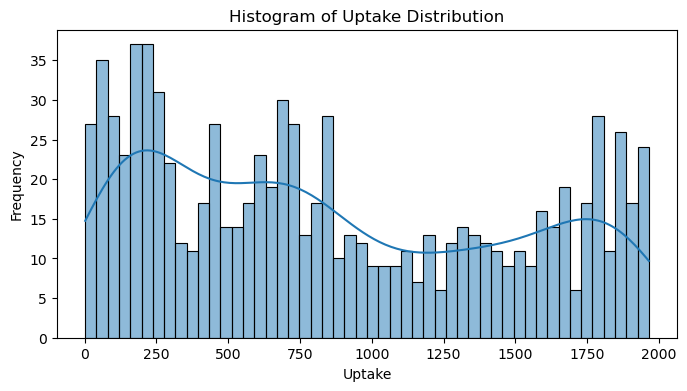

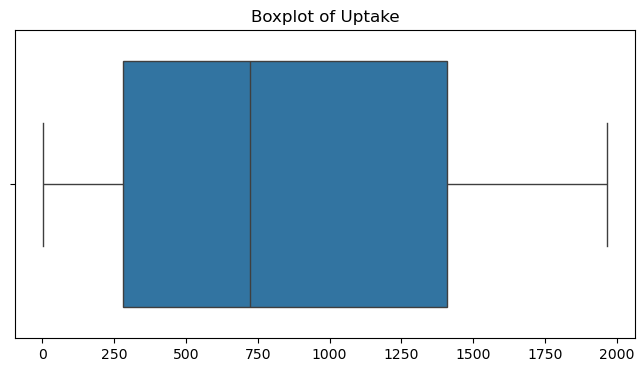

/var/folders/qh/n3ln1st96g91tlkklrwc8c480000gn/T/ipykernel_70501/2937836795.py:100: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.expm1(y_train), label='Train', shade=True)
/var/folders/qh/n3ln1st96g91tlkklrwc8c480000gn/T/ipykernel_70501/2937836795.py:101: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.expm1(y_test), label='Test', shade=True)


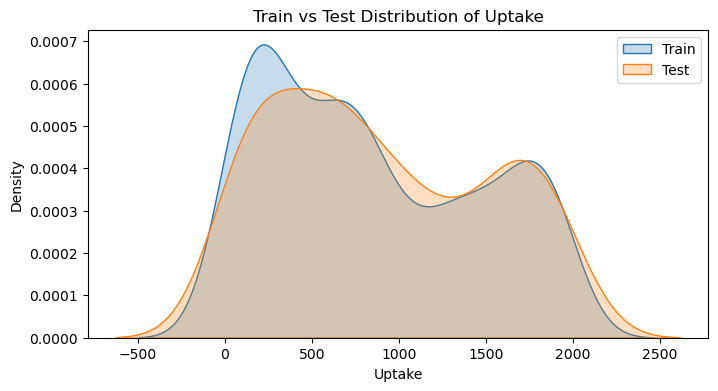

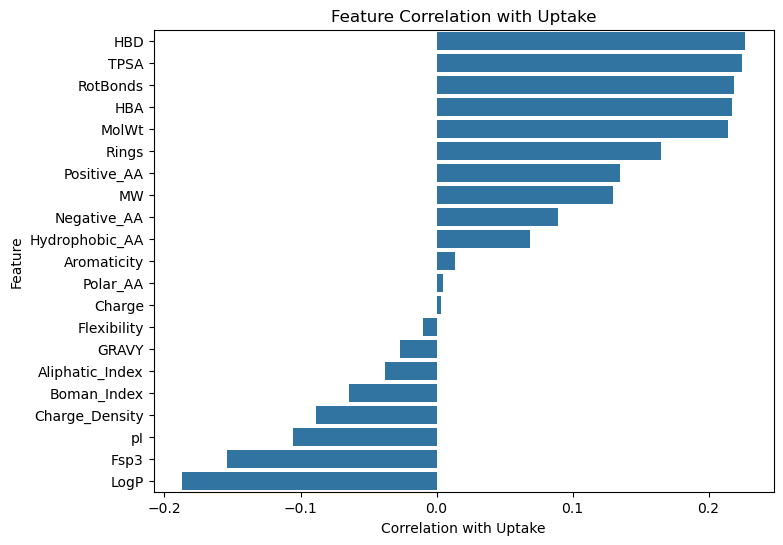

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Select only meaningful features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract only the selected features
X_numerical = df4[selected_features]

# Combine all features (numerical descriptors + embeddings)
X = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Log-transform the target variable ===
y = np.log1p(y)  # log(1 + y) to avoid log(0)

# === 4. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 5. Train Random Forest Regressor ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === 6. Evaluate model ===
y_pred_transformed = model.predict(X_test)
y_pred = np.expm1(y_pred_transformed)  # Reverse transformation

y_test_original = np.expm1(y_test)  # Reverse transformation for evaluation
mae = mean_absolute_error(y_test_original, y_pred)
print(f"Mean Absolute Error (original scale): {mae:.4f}")

# === 7. Feature Importance ===
feature_importances = model.feature_importances_

# Get feature names
num_features = X_numerical.shape[1]
feature_names = selected_features + \
                [f"blomap_{i}" for i in range(blomap_embeddings.shape[1])] + \
                [f"fp_{i}" for i in range(fingerprints_embeddings.shape[1])] + \
                [f"protbert_{i}" for i in range(protbert_embeddings.shape[1])]

# Sort importances
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# === 8. Plot Feature Importance ===
plt.figure(figsize=(12, 6))
plt.barh(sorted_features[:20], sorted_importances[:20])  # Top 20 features
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features for Uptake Prediction (Filtered)")
plt.gca().invert_yaxis()
plt.show()

# === 9. Visualization ===
print("Descriptive Statistics for Uptake")
print(pd.Series(np.expm1(y)).describe())

# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(np.expm1(y), bins=50, kde=True)
plt.xlabel("Uptake")
plt.ylabel("Frequency")
plt.title("Histogram of Uptake Distribution")
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=np.expm1(y))
plt.title("Boxplot of Uptake")
plt.show()

# Train vs Test Distribution
plt.figure(figsize=(8, 4))
sns.kdeplot(np.expm1(y_train), label='Train', shade=True)
sns.kdeplot(np.expm1(y_test), label='Test', shade=True)
plt.xlabel("Uptake")
plt.ylabel("Density")
plt.title("Train vs Test Distribution of Uptake")
plt.legend()
plt.show()

# Correlation with Uptake
correlation_matrix = pd.DataFrame(X_numerical, columns=selected_features)
correlation_matrix['uptake'] = np.expm1(y)
corrs = correlation_matrix.corr()['uptake'].drop('uptake').sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(y=corrs.index, x=corrs.values)
plt.xlabel("Correlation with Uptake")
plt.ylabel("Feature")
plt.title("Feature Correlation with Uptake")
plt.show()


вдохновленнный пасейдоном-- XGBoost, HBD/HBA Ratio, TPSA/LogP Ratio , Optuna, log10(uptake)

In [14]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 866.8 kB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 501.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 261.9 kB/s eta 0:00:00a 0:00:01


/var/folders/qh/n3ln1st96g91tlkklrwc8c480000gn/T/ipykernel_70501/413467948.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical["HBD_HBA_Ratio"] = X_numerical["HBD"] / (X_numerical["HBA"] + 1e-6)
/var/folders/qh/n3ln1st96g91tlkklrwc8c480000gn/T/ipykernel_70501/413467948.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical["TPSA_LogP_Ratio"] = X_numerical["TPSA"] / (X_numerical["LogP"] + 1e-6)
[I 2025-02-22 17:08:09,126] A new study created in memory with name: no-name-18172b3b-da25-4

Mean Absolute Error (original scale): 321.5812


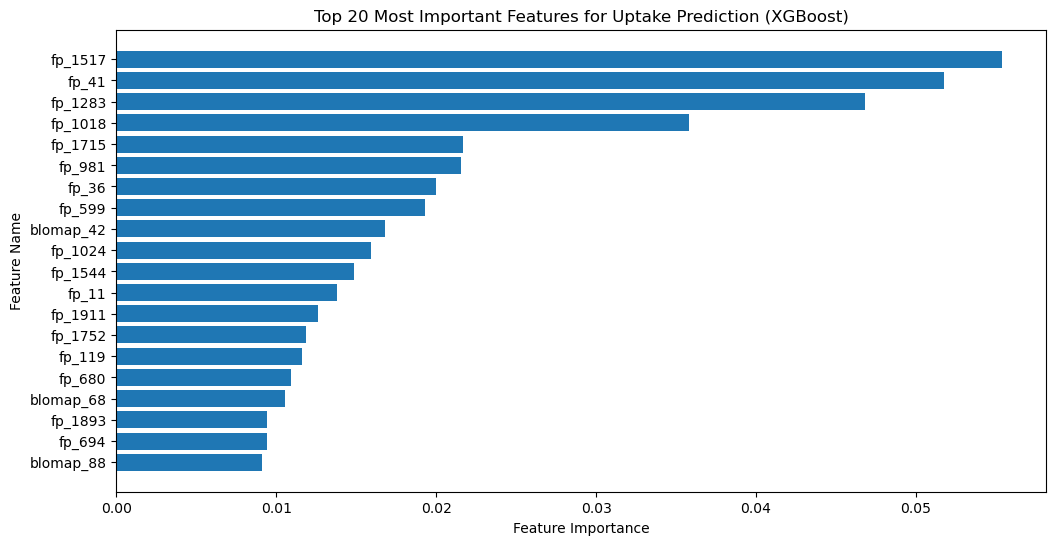

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import optuna

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features]

# Generate additional features
X_numerical["HBD_HBA_Ratio"] = X_numerical["HBD"] / (X_numerical["HBA"] + 1e-6)
X_numerical["TPSA_LogP_Ratio"] = X_numerical["TPSA"] / (X_numerical["LogP"] + 1e-6)

# Combine all features
X = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Log-transform uptake ===
y = np.log1p(y)

# === 4. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 5. Optimize XGBoost ===
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0)
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best_params = study.best_params

# === 6. Train XGBoost with best params ===
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

y_pred_transformed = model.predict(X_test)
y_pred = np.expm1(y_pred_transformed)
y_test_original = np.expm1(y_test)

mae = mean_absolute_error(y_test_original, y_pred)
print(f"Mean Absolute Error (original scale): {mae:.4f}")

# === 7. Feature Importance ===
feature_importances = model.feature_importances_

num_features = X_numerical.shape[1]
feature_names = selected_features + ["HBD_HBA_Ratio", "TPSA_LogP_Ratio"] + \
                [f"blomap_{i}" for i in range(blomap_embeddings.shape[1])] + \
                [f"fp_{i}" for i in range(fingerprints_embeddings.shape[1])] + \
                [f"protbert_{i}" for i in range(protbert_embeddings.shape[1])]

sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(12, 6))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features for Uptake Prediction (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


One-hot encoding  for cell line and positions of aa

теперь pca для фингерпринтов(150 главныз компонент )+ градиентный бустинг+ нейросеть

In [20]:
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost lightgbm optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.5 MB/s eta 0:00:0000:0100:010m


In [21]:
!pip install torch torchvision torchaudio  # если хочешь MLP на PyTorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 561.1 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 496.2 kB/s eta 0:00:0000:0100:01


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
import optuna

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. PCA on Fingerprints (Increasing Components to 100) ===
pca = PCA(n_components=100, random_state=42)
fingerprints_pca = pca.fit_transform(fingerprints_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# Generate additional features
X_numerical.loc[:, "HBD_HBA_Ratio"] = X_numerical["HBD"] / (X_numerical["HBA"] + 1e-6)
X_numerical.loc[:, "TPSA_LogP_Ratio"] = X_numerical["TPSA"] / (X_numerical["LogP"] + 1e-6)

# === 5. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 6. One-hot encoding for amino acids (position-based) ===
def one_hot_encode_sequence(sequence, max_length=30):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    encoding = np.zeros((max_length, len(amino_acids)))
    for i, aa in enumerate(sequence[:max_length]):
        if aa in amino_acids:
            encoding[i, amino_acids.index(aa)] = 1
    return encoding.flatten()

if "standard_sequence" in df4.columns:
    max_seq_length = 30  # Учитываем первые 30 позиций
    encoded_sequences = np.array([one_hot_encode_sequence(seq, max_seq_length) for seq in df4["standard_sequence"]])
    sequence_feature_names = [f"AA_{i}_{aa}" for i in range(max_seq_length) for aa in "ACDEFGHIKLMNPQRSTVWY"]
    X_sequence = pd.DataFrame(encoded_sequences, columns=sequence_feature_names)
else:
    X_sequence = pd.DataFrame()

# === 7. Combine all features ===
X = np.hstack([X_numerical, blomap_embeddings, fingerprints_pca, protbert_embeddings])
if not X_cell_line.empty:
    X = np.hstack([X, X_cell_line])
if not X_sequence.empty:
    X = np.hstack([X, X_sequence])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# === Log-transform uptake ===
y = np.log1p(y)

# === 8. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 9. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test))

# === 10. Train LightGBM ===
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_data_in_leaf=10,  # Минимум 10 объектов в листе
    num_leaves=31,        # Ограничиваем число листьев
    random_state=42
)
lgbm_model.fit(X_train, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test))

# === 11. Train MLP ===
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = np.expm1(mlp_model.predict(X_test))

# === 12. Ensemble (Average of XGBoost, LightGBM, MLP) ===
ensemble_pred = (xgb_pred + lgbm_pred + mlp_pred) / 3

# === 13. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_mlp = mean_absolute_error(y_test_original, mlp_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE MLP: {mae_mlp:.4f}")
print(f"MAE Ensemble: {mae_ensemble:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29567
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 893
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

StandardScaler перед MLP, число нейронов (200-100-50) и число итераций (max_iter=1000),   loss_curve_ (учится ли MLP или просто гадает?????)


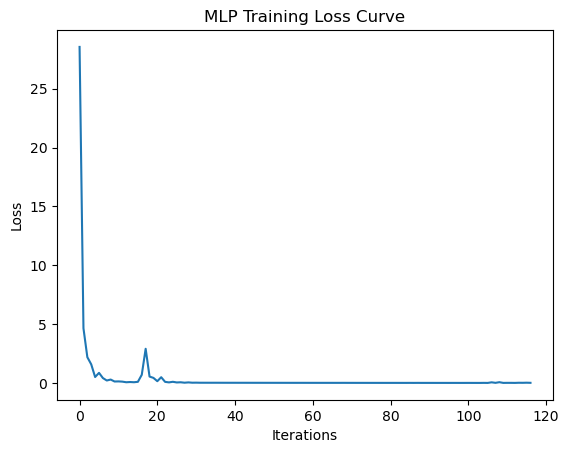

MAE MLP: 572.5472


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
import optuna

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. PCA on Fingerprints (Increasing Components to 100) ===
pca = PCA(n_components=100, random_state=42)
fingerprints_pca = pca.fit_transform(fingerprints_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# Generate additional features
X_numerical.loc[:, "HBD_HBA_Ratio"] = X_numerical["HBD"] / (X_numerical["HBA"] + 1e-6)
X_numerical.loc[:, "TPSA_LogP_Ratio"] = X_numerical["TPSA"] / (X_numerical["LogP"] + 1e-6)

# === 5. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 6. One-hot encoding for amino acids (position-based) ===
def one_hot_encode_sequence(sequence, max_length=30):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    encoding = np.zeros((max_length, len(amino_acids)))
    for i, aa in enumerate(sequence[:max_length]):
        if aa in amino_acids:
            encoding[i, amino_acids.index(aa)] = 1
    return encoding.flatten()

if "standard_sequence" in df4.columns:
    max_seq_length = 30  # Учитываем первые 30 позиций
    encoded_sequences = np.array([one_hot_encode_sequence(seq, max_seq_length) for seq in df4["standard_sequence"]])
    sequence_feature_names = [f"AA_{i}_{aa}" for i in range(max_seq_length) for aa in "ACDEFGHIKLMNPQRSTVWY"]
    X_sequence = pd.DataFrame(encoded_sequences, columns=sequence_feature_names)
else:
    X_sequence = pd.DataFrame()

# === 7. Combine all features ===
X = np.hstack([X_numerical, blomap_embeddings, fingerprints_pca, protbert_embeddings])
if not X_cell_line.empty:
    X = np.hstack([X, X_cell_line])
if not X_sequence.empty:
    X = np.hstack([X, X_sequence])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# === Log-transform uptake ===
y = np.log1p(y)

# === 8. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Normalize data for MLP ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 9. Train MLP with L2 Regularization ===
mlp_model = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),
    activation='relu',
    alpha=0.0001,
    max_iter=1000,
    solver='adam',  
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)
mlp_pred = np.expm1(np.clip(mlp_model.predict(X_test_scaled), -10, 10))  # Ограничение амплитуды

# === 10. Plot MLP Loss Curve ===
plt.plot(mlp_model.loss_curve_)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP Training Loss Curve")
plt.show()

# === 11. Check for NaN/Inf in Predictions ===
if np.isnan(mlp_pred).any() or np.isinf(mlp_pred).any():
    print("WARNING: MLP predictions contain NaN or Infinity values!")

# === 12. Evaluate ===
y_test_original = np.expm1(y_test)
mae_mlp = mean_absolute_error(y_test_original, mlp_pred)

print(f"MAE MLP: {mae_mlp:.4f}")


In [ ]:
останавлваемся на варианте 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. PCA on Fingerprints (Increasing Components to 100) ===
pca = PCA(n_components=100, random_state=42)
fingerprints_pca = pca.fit_transform(fingerprints_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# Generate additional features
X_numerical.loc[:, "HBD_HBA_Ratio"] = X_numerical["HBD"] / (X_numerical["HBA"] + 1e-6)
X_numerical.loc[:, "TPSA_LogP_Ratio"] = X_numerical["TPSA"] / (X_numerical["LogP"] + 1e-6)

# === 5. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 6. One-hot encoding for amino acids (position-based) ===
def one_hot_encode_sequence(sequence, max_length=30):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    encoding = np.zeros((max_length, len(amino_acids)))
    for i, aa in enumerate(sequence[:max_length]):
        if aa in amino_acids:
            encoding[i, amino_acids.index(aa)] = 1
    return encoding.flatten()

if "standard_sequence" in df4.columns:
    max_seq_length = 30  # Учитываем первые 30 позиций
    encoded_sequences = np.array([one_hot_encode_sequence(seq, max_seq_length) for seq in df4["standard_sequence"]])
    sequence_feature_names = [f"AA_{i}_{aa}" for i in range(max_seq_length) for aa in "ACDEFGHIKLMNPQRSTVWY"]
    X_sequence = pd.DataFrame(encoded_sequences, columns=sequence_feature_names)
else:
    X_sequence = pd.DataFrame()

# === 7. Combine all features ===
X = np.hstack([X_numerical, blomap_embeddings, fingerprints_pca, protbert_embeddings])
if not X_cell_line.empty:
    X = np.hstack([X, X_cell_line])
if not X_sequence.empty:
    X = np.hstack([X, X_sequence])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# === Log-transform uptake ===
y = np.log1p(y)

# === 8. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 9. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test))

# === 10. Train LightGBM ===
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_data_in_leaf=10,
    num_leaves=31,
    random_state=42
)
lgbm_model.fit(X_train, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test))

# === 11. Ensemble (Average of XGBoost, LightGBM) ===
ensemble_pred = (xgb_pred + lgbm_pred) / 2

# === 12. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE Ensemble: {mae_ensemble:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29567
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 893
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

плохо,плохо... поэтому -- Тест без PCA / без новых фич


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings (Without PCA) ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Select features (No new features) ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# === 4. One-hot encoding for cell_line (Keep) ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 5. Combine all features (No PCA) ===
X = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X = np.hstack([X, X_cell_line])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# === Log-transform uptake ===
y = np.log1p(y)

# === 6. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 7. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test))

# === 8. Train LightGBM ===
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_data_in_leaf=10,
    num_leaves=31,
    random_state=42
)
lgbm_model.fit(X_train, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test))

# === 9. Ensemble (Average of XGBoost, LightGBM) ===
ensemble_pred = (xgb_pred + lgbm_pred) / 2

# === 10. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE Ensemble: {mae_ensemble:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 706
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

кэтбуст

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# === 4. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 5. Combine all features ===
X = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X = np.hstack([X, X_cell_line])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# === Log-transform uptake ===
y = np.log1p(y)

# === 6. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 7. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test))

# === 8. Train LightGBM ===
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_data_in_leaf=10,
    num_leaves=31,
    random_state=42
)
lgbm_model.fit(X_train, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test))

# === 9. Train CatBoost ===
catboost_model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=0
)
catboost_model.fit(X_train, y_train)
catboost_pred = np.expm1(catboost_model.predict(X_test))

# === 10. Ensemble (Average of XGBoost, LightGBM, CatBoost) ===
ensemble_pred = (xgb_pred + lgbm_pred + catboost_pred) / 3

# === 11. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_catboost = mean_absolute_error(y_test_original, catboost_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE CatBoost: {mae_catboost:.4f}")
print(f"MAE Ensemble: {mae_ensemble:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 706
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [ ]:
 Blomap embeddings с помощью PCA 

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Reduce dimensionality of Blomap embeddings ===
pca_blomap = PCA(n_components=10, random_state=42)
blomap_pca = pca_blomap.fit_transform(blomap_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# === 5. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 6. Combine all features ===
X = np.hstack([X_numerical, blomap_pca, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X = np.hstack([X, X_cell_line])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# === Log-transform uptake ===
y = np.log1p(y)

# === 7. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 8. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test))

# === 9. Train LightGBM ===
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_data_in_leaf=10,
    num_leaves=31,
    random_state=42
)
lgbm_model.fit(X_train, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test))

# === 10. Ensemble (Average of XGBoost, LightGBM) ===
ensemble_pred = (xgb_pred + lgbm_pred) / 2

# === 11. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE Ensemble: {mae_ensemble:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6769
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 572
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Reduce dimensionality of Blomap embeddings ===
pca_blomap = PCA(n_components=10, random_state=42)
blomap_pca = pca_blomap.fit_transform(blomap_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# === 5. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 6. Combine all features ===
X = np.hstack([X_numerical, blomap_pca, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X = np.hstack([X, X_cell_line])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# === Log-transform uptake ===
y = np.log1p(y)

# === 7. Train test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 8. Optuna Optimization for XGBoost ===
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 42
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    pred = np.expm1(model.predict(X_test))
    return mean_absolute_error(np.expm1(y_test), pred)

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=50)
best_xgb_params = study_xgb.best_params

xgb_model = XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test))

# === 9. Optuna Optimization for LightGBM ===
def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
        "random_state": 42
    }
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    pred = np.expm1(model.predict(X_test))
    return mean_absolute_error(np.expm1(y_test), pred)

study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=50)
best_lgbm_params = study_lgbm.best_params

lgbm_model = LGBMRegressor(**best_lgbm_params)
lgbm_model.fit(X_train, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test))

# === 10. Ensemble (Average of XGBoost, LightGBM) ===
ensemble_pred = (xgb_pred + lgbm_pred) / 2

# === 11. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"Best XGBoost Params: {best_xgb_params}")
print(f"Best LightGBM Params: {best_lgbm_params}")
print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE Ensemble: {mae_ensemble:.4f}")


[I 2025-02-22 18:24:47,092] A new study created in memory with name: no-name-706241bb-a934-4e2c-b6a1-4cce97a2c7a1
[I 2025-02-22 18:24:49,294] Trial 0 finished with value: 307.8667881705544 and parameters: {'n_estimators': 308, 'max_depth': 5, 'learning_rate': 0.025329545725866973, 'subsample': 0.8436690039976387, 'colsample_bytree': 0.8907585037520658}. Best is trial 0 with value: 307.8667881705544.
[I 2025-02-22 18:25:01,621] Trial 1 finished with value: 287.3739632042971 and parameters: {'n_estimators': 868, 'max_depth': 15, 'learning_rate': 0.048331158215150695, 'subsample': 0.6827747525394547, 'colsample_bytree': 0.876677576058624}. Best is trial 1 with value: 287.3739632042971.
[I 2025-02-22 18:25:04,395] Trial 2 finished with value: 304.1943500692194 and parameters: {'n_estimators': 176, 'max_depth': 11, 'learning_rate': 0.03561631096727367, 'subsample': 0.5972989040827765, 'colsample_bytree': 0.6135566233066959}. Best is trial 1 with value: 287.3739632042971.
[I 2025-02-22 18:25

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 279
[LightGBM] [Info] Start training from score 6.308943


[I 2025-02-22 18:29:01,371] Trial 0 finished with value: 324.8137875280441 and parameters: {'n_estimators': 955, 'learning_rate': 0.06134321108651472, 'num_leaves': 17, 'min_data_in_leaf': 11}. Best is trial 0 with value: 324.8137875280441.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5491
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 218
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-02-22 18:29:02,508] Trial 1 finished with value: 355.97850349418246 and parameters: {'n_estimators': 940, 'learning_rate': 0.19350134703949706, 'num_leaves': 96, 'min_data_in_leaf': 39}. Best is trial 0 with value: 324.8137875280441.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:02,696] Trial 2 finished with value: 386.3629960157466 and parameters: {'n_estimators': 136, 'learning_rate': 0.043215049212614244, 'num_leaves': 69, 'min_data_in_leaf': 43}. Best is trial 0 with value: 324.8137875280441.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:03,726] Trial 3 finished with value: 312.08426946874914 and parameters: {'n_estimators': 418, 'learning_rate': 0.1173944745911163, 'num_leaves': 97, 'min_data_in_leaf': 18}. Best is trial 3 with value: 312.08426946874914.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:04,580] Trial 4 finished with value: 369.2333417370522 and parameters: {'n_estimators': 557, 'learning_rate': 0.03175357382366785, 'num_leaves': 87, 'min_data_in_leaf': 42}. Best is trial 3 with value: 312.08426946874914.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:05,658] Trial 5 finished with value: 364.42858302757645 and parameters: {'n_estimators': 884, 'learning_rate': 0.20714885012607362, 'num_leaves': 42, 'min_data_in_leaf': 37}. Best is trial 3 with value: 312.08426946874914.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5487
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 216
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-02-22 18:29:06,260] Trial 6 finished with value: 361.1175342207227 and parameters: {'n_estimators': 566, 'learning_rate': 0.04638191033705152, 'num_leaves': 32, 'min_data_in_leaf': 41}. Best is trial 3 with value: 312.08426946874914.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7568
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 798
[LightGBM] [Info] Start training from score 6.308943


[I 2025-02-22 18:29:07,431] Trial 7 finished with value: 283.3188674167602 and parameters: {'n_estimators': 266, 'learning_rate': 0.01951831296349992, 'num_leaves': 39, 'min_data_in_leaf': 9}. Best is trial 7 with value: 283.3188674167602.
[I 2025-02-22 18:29:07,608] Trial 8 finished with value: 421.51796014688057 and parameters: {'n_estimators': 197, 'learning_rate': 0.013578416165707225, 'num_leaves': 10, 'min_data_in_leaf': 41}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5487
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 216
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, mi

[I 2025-02-22 18:29:08,155] Trial 9 finished with value: 377.51383757182646 and parameters: {'n_estimators': 550, 'learning_rate': 0.017321159609211663, 'num_leaves': 16, 'min_data_in_leaf': 42}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:10,578] Trial 10 finished with value: 313.40803549369343 and parameters: {'n_estimators': 326, 'learning_rate': 0.010269302508677672, 'num_leaves': 60, 'min_data_in_leaf': 5}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5559
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 252
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-02-22 18:29:11,270] Trial 11 finished with value: 337.12218696476975 and parameters: {'n_estimators': 342, 'learning_rate': 0.0852863725241785, 'num_leaves': 75, 'min_data_in_leaf': 20}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:12,196] Trial 12 finished with value: 340.7729623776269 and parameters: {'n_estimators': 388, 'learning_rate': 0.15255819143172897, 'num_leaves': 46, 'min_data_in_leaf': 18}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5539
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 242
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2025-02-22 18:29:12,815] Trial 13 finished with value: 344.51946548130906 and parameters: {'n_estimators': 419, 'learning_rate': 0.09912012623349811, 'num_leaves': 34, 'min_data_in_leaf': 28}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:14,802] Trial 14 finished with value: 309.57384957374853 and parameters: {'n_estimators': 719, 'learning_rate': 0.023542612744867963, 'num_leaves': 58, 'min_data_in_leaf': 15}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:19,225] Trial 15 finished with value: 299.98340094109926 and parameters: {'n_estimators': 724, 'learning_rate': 0.02426879043333471, 'num_leaves': 52, 'min_data_in_leaf': 5}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9364
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 1279
[LightGBM] [Info] Start training from score 6.308943


[I 2025-02-22 18:29:24,854] Trial 16 finished with value: 304.4027252759526 and parameters: {'n_estimators': 759, 'learning_rate': 0.025686456641129563, 'num_leaves': 49, 'min_data_in_leaf': 5}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5541
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 243
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-02-22 18:29:27,038] Trial 17 finished with value: 334.70211288809594 and parameters: {'n_estimators': 718, 'learning_rate': 0.017644119011824267, 'num_leaves': 27, 'min_data_in_leaf': 26}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:31,549] Trial 18 finished with value: 297.64628235163667 and parameters: {'n_estimators': 794, 'learning_rate': 0.03462823047671253, 'num_leaves': 70, 'min_data_in_leaf': 10}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5461
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 203
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[I 2025-02-22 18:29:32,367] Trial 19 finished with value: 348.9180875939255 and parameters: {'n_estimators': 820, 'learning_rate': 0.03593783407205461, 'num_leaves': 73, 'min_data_in_leaf': 49}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5545
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 245
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-02-22 18:29:33,350] Trial 20 finished with value: 336.99959190902064 and parameters: {'n_estimators': 638, 'learning_rate': 0.010452429650646243, 'num_leaves': 85, 'min_data_in_leaf': 25}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:29:41,822] Trial 21 finished with value: 286.1670085782752 and parameters: {'n_estimators': 827, 'learning_rate': 0.02179596804729929, 'num_leaves': 63, 'min_data_in_leaf': 9}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 279
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-02-22 18:29:49,266] Trial 22 finished with value: 316.9155724588541 and parameters: {'n_estimators': 841, 'learning_rate': 0.05796409816171683, 'num_leaves': 63, 'min_data_in_leaf': 11}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=9, min_c

[I 2025-02-22 18:29:58,505] Trial 23 finished with value: 283.9898922887119 and parameters: {'n_estimators': 997, 'learning_rate': 0.01725174750390943, 'num_leaves': 67, 'min_data_in_leaf': 9}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5601
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 273
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-02-22 18:30:01,690] Trial 24 finished with value: 307.56857286007886 and parameters: {'n_estimators': 1000, 'learning_rate': 0.017684402744505015, 'num_leaves': 40, 'min_data_in_leaf': 13}. Best is trial 7 with value: 283.3188674167602.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7568
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 798
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-02-22 18:30:03,686] Trial 25 finished with value: 278.3418767810939 and parameters: {'n_estimators': 252, 'learning_rate': 0.013308955237719354, 'num_leaves': 80, 'min_data_in_leaf': 9}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007249 seconds.
You can

[I 2025-02-22 18:30:04,639] Trial 26 finished with value: 358.7878030028962 and parameters: {'n_estimators': 232, 'learning_rate': 0.013312524270533045, 'num_leaves': 82, 'min_data_in_leaf': 22}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[Light

[I 2025-02-22 18:30:06,493] Trial 27 finished with value: 319.36938024898205 and parameters: {'n_estimators': 263, 'learning_rate': 0.01309234767758989, 'num_leaves': 80, 'min_data_in_leaf': 15}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5513
[LightGBM] [Info] Number of data points in the train set: 701, 

[I 2025-02-22 18:30:07,921] Trial 28 finished with value: 350.01132218188826 and parameters: {'n_estimators': 478, 'learning_rate': 0.016728163719406153, 'num_leaves': 53, 'min_data_in_leaf': 32}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=8, min_c

[I 2025-02-22 18:30:09,445] Trial 29 finished with value: 281.18166497842105 and parameters: {'n_estimators': 111, 'learning_rate': 0.0663011201947221, 'num_leaves': 90, 'min_data_in_leaf': 8}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5601
[

[I 2025-02-22 18:30:09,961] Trial 30 finished with value: 304.6198062226543 and parameters: {'n_estimators': 101, 'learning_rate': 0.06810680378803753, 'num_leaves': 91, 'min_data_in_leaf': 13}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:30:12,772] Trial 31 finished with value: 280.89074851012793 and parameters: {'n_estimators': 186, 'learning_rate': 0.06941137493521507, 'num_leaves': 90, 'min_data_in_leaf': 8}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored.

[I 2025-02-22 18:30:15,462] Trial 32 finished with value: 287.0523869229009 and parameters: {'n_estimators': 173, 'learning_rate': 0.07053348715205206, 'num_leaves': 90, 'min_data_in_leaf': 8}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9342
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 1268
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2025-02-22 18:30:23,969] Trial 33 finished with value: 297.50771787798726 and parameters: {'n_estimators': 291, 'learning_rate': 0.29611986314719185, 'num_leaves': 99, 'min_data_in_leaf': 7}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5601
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 273
[LightGBM] [Info] Start training from score 6.308943
[Light

[I 2025-02-22 18:30:24,928] Trial 34 finished with value: 310.9709248486826 and parameters: {'n_estimators': 159, 'learning_rate': 0.046910260844239514, 'num_leaves': 92, 'min_data_in_leaf': 13}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Info] Auto-choosing ro

[I 2025-02-22 18:30:25,650] Trial 35 finished with value: 320.74971997261764 and parameters: {'n_estimators': 106, 'learning_rate': 0.08775576870518194, 'num_leaves': 80, 'min_data_in_leaf': 16}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:30:27,294] Trial 36 finished with value: 310.71871504456453 and parameters: {'n_estimators': 231, 'learning_rate': 0.056812122997558424, 'num_leaves': 100, 'min_data_in_leaf': 12}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062675 seconds.
You can s

[I 2025-02-22 18:30:31,177] Trial 37 finished with value: 302.4075162980062 and parameters: {'n_estimators': 208, 'learning_rate': 0.11704173157469096, 'num_leaves': 94, 'min_data_in_leaf': 7}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5571
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 258
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-02-22 18:30:32,880] Trial 38 finished with value: 334.3715172629068 and parameters: {'n_estimators': 290, 'learning_rate': 0.04090412982369089, 'num_leaves': 76, 'min_data_in_leaf': 18}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value

[I 2025-02-22 18:30:34,584] Trial 39 finished with value: 337.73408009562553 and parameters: {'n_estimators': 482, 'learning_rate': 0.030470609984055794, 'num_leaves': 87, 'min_data_in_leaf': 22}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:30:36,097] Trial 40 finished with value: 324.1632323582473 and parameters: {'n_estimators': 359, 'learning_rate': 0.15941861815005728, 'num_leaves': 26, 'min_data_in_leaf': 11}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 1039
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-22 18:30:37,443] Trial 41 finished with value: 305.6336515426102 and parameters: {'n_estimators': 164, 'learning_rate': 0.014688510629230433, 'num_leaves': 67, 'min_data_in_leaf': 8}. Best is trial 25 with value: 278.3418767810939.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7568
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 798
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-02-22 18:30:43,342] Trial 42 finished with value: 276.29458773995 and parameters: {'n_estimators': 629, 'learning_rate': 0.0114315426267485, 'num_leaves': 77, 'min_data_in_leaf': 9}. Best is trial 42 with value: 276.29458773995.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9356
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 1275
[LightGBM] [Info] Start training from score 6.308943


[I 2025-02-22 18:30:52,020] Trial 43 finished with value: 278.2932004476196 and parameters: {'n_estimators': 598, 'learning_rate': 0.012422799961910433, 'num_leaves': 85, 'min_data_in_leaf': 6}. Best is trial 42 with value: 276.29458773995.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9356
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 1275
[LightGBM] [Info] Start training from score 6.308943


[I 2025-02-22 18:31:00,109] Trial 44 finished with value: 280.9247124103985 and parameters: {'n_estimators': 621, 'learning_rate': 0.010109159342090817, 'num_leaves': 85, 'min_data_in_leaf': 6}. Best is trial 42 with value: 276.29458773995.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9364
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 1279
[LightGBM] [Info] Start training from score 6.308943


[I 2025-02-22 18:31:10,670] Trial 45 finished with value: 296.58596920280684 and parameters: {'n_estimators': 637, 'learning_rate': 0.01161431395366537, 'num_leaves': 77, 'min_data_in_leaf': 5}. Best is trial 42 with value: 276.29458773995.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5577
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 261
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-02-22 18:31:13,280] Trial 46 finished with value: 313.6783645699823 and parameters: {'n_estimators': 641, 'learning_rate': 0.011562608798386506, 'num_leaves': 84, 'min_data_in_leaf': 16}. Best is trial 42 with value: 276.29458773995.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:31:15,519] Trial 47 finished with value: 353.5460168045124 and parameters: {'n_estimators': 597, 'learning_rate': 0.011809836890712565, 'num_leaves': 96, 'min_data_in_leaf': 35}. Best is trial 42 with value: 276.29458773995.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 18:31:22,238] Trial 48 finished with value: 284.5433716385085 and parameters: {'n_estimators': 474, 'learning_rate': 0.010259491069571827, 'num_leaves': 72, 'min_data_in_leaf': 6}. Best is trial 42 with value: 276.29458773995.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 272
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-02-22 18:31:24,308] Trial 49 finished with value: 313.7785351056243 and parameters: {'n_estimators': 674, 'learning_rate': 0.014609479595107276, 'num_leaves': 87, 'min_data_in_leaf': 14}. Best is trial 42 with value: 276.29458773995.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7568
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 798
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Используем PCA на Blomap только для XGBoost, а для LightGBM оставляем просто Blomap.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Reduce dimensionality of Blomap for XGBoost ===
pca_blomap = PCA(n_components=10, random_state=42)
blomap_pca = pca_blomap.fit_transform(blomap_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# === 5. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 6. Prepare X for XGBoost (PCA on Blomap) ===
X_xgb = np.hstack([X_numerical, blomap_pca, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X_xgb = np.hstack([X_xgb, X_cell_line])

# === 7. Prepare X for LightGBM (Full Blomap) ===
X_lgbm = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X_lgbm = np.hstack([X_lgbm, X_cell_line])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X_xgb = X_xgb[valid_idx]
X_lgbm = X_lgbm[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X_xgb = imputer.fit_transform(X_xgb)
X_lgbm = imputer.fit_transform(X_lgbm)

# === Log-transform uptake ===
y = np.log1p(y)

# === 8. Train test split ===
X_train_xgb, X_test_xgb, y_train, y_test = train_test_split(X_xgb, y, test_size=0.2, random_state=42)
X_train_lgbm, X_test_lgbm, _, _ = train_test_split(X_lgbm, y, test_size=0.2, random_state=42)

# === 9. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42)
xgb_model.fit(X_train_xgb, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test_xgb))

# === 10. Train LightGBM ===
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_data_in_leaf=10,
    num_leaves=31,
    random_state=42
)
lgbm_model.fit(X_train_lgbm, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test_lgbm))

# === 11. Ensemble (Average of XGBoost, LightGBM) ===
ensemble_pred = (xgb_pred + lgbm_pred) / 2

# === 12. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE Ensemble: {mae_ensemble:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 706
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

пробую веса-- max_depth=7 для LightGBM, 
проверка на дубликаты признаков (корреляция > 0.98).
веса в ансамбле (0.7 XGBoost + 0.3 LightGBM).

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Reduce dimensionality of Blomap for XGBoost ===
pca_blomap = PCA(n_components=10, random_state=42)
blomap_pca = pca_blomap.fit_transform(blomap_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# === 5. Check for duplicate features ===
corr_matrix = pd.DataFrame(np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])).corr()
high_corr_features = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.98)]
print(f"Highly correlated features (corr > 0.98) to consider removing: {high_corr_features}")

# === 6. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 7. Prepare X for XGBoost (PCA on Blomap) ===
X_xgb = np.hstack([X_numerical, blomap_pca, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X_xgb = np.hstack([X_xgb, X_cell_line])

# === 8. Prepare X for LightGBM (Full Blomap) ===
X_lgbm = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X_lgbm = np.hstack([X_lgbm, X_cell_line])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X_xgb = X_xgb[valid_idx]
X_lgbm = X_lgbm[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X_xgb = imputer.fit_transform(X_xgb)
X_lgbm = imputer.fit_transform(X_lgbm)

# === Log-transform uptake ===
y = np.log1p(y)

# === 9. Train test split ===
X_train_xgb, X_test_xgb, y_train, y_test = train_test_split(X_xgb, y, test_size=0.2, random_state=42)
X_train_lgbm, X_test_lgbm, _, _ = train_test_split(X_lgbm, y, test_size=0.2, random_state=42)

# === 10. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=754, max_depth=6, learning_rate=0.054886325307314195,
                         subsample=0.9967873263465272, colsample_bytree=0.8645926672674225,
                         random_state=42)
xgb_model.fit(X_train_xgb, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test_xgb))

# === 11. Train LightGBM (Reduced max_depth to prevent overfitting) ===
lgbm_model = LGBMRegressor(
    n_estimators=629,
    learning_rate=0.0114315426267485,
    num_leaves=77,
    min_data_in_leaf=9,
    max_depth=7,  # Reduced depth to prevent overfitting
    random_state=42
)
lgbm_model.fit(X_train_lgbm, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test_lgbm))

# === 12. Ensemble with adjusted weights (XGBoost 70%, LightGBM 30%) ===
ensemble_pred = (0.7 * xgb_pred + 0.3 * lgbm_pred)

# === 13. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"Highly correlated features (corr > 0.98) to consider removing: {high_corr_features}")
print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE Ensemble (70% XGBoost, 30% LightGBM): {mae_ensemble:.4f}")


Highly correlated features (corr > 0.98) to consider removing: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 96, 97, 98, 99, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 116, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 149, 151, 152, 153, 154, 156, 157, 158, 159, 161, 162, 163, 164, 166, 167, 168, 169, 171, 172, 173, 174, 176, 177, 178, 179, 181, 182, 183, 184, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 198, 199, 201, 202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 216, 217, 218, 219, 221, 222, 223, 224, 226, 227, 228, 229, 231, 232, 234, 236, 237, 238, 239, 241, 242, 243, 244, 246, 247, 248, 249, 251, 252, 2

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Reduce dimensionality of Blomap for XGBoost ===
pca_blomap = PCA(n_components=10, random_state=42)
blomap_pca = pca_blomap.fit_transform(blomap_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# === 5. Check for duplicate features and remove them ===
all_features = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
corr_matrix = pd.DataFrame(all_features).corr()
high_corr_features = [i for i in range(corr_matrix.shape[1]) if any(corr_matrix.iloc[:, i] > 0.98)]

# Удаляем только те признаки, которые есть в X_numerical
existing_high_corr_features = [i for i in high_corr_features if i < X_numerical.shape[1]]
X_numerical = X_numerical.drop(columns=[X_numerical.columns[i] for i in existing_high_corr_features], errors='ignore')

# Удаляем коррелированные признаки из других матриц, проверяя границы индексов
blomap_corr_indices = [i - X_numerical.shape[1] for i in high_corr_features if X_numerical.shape[1] <= i < X_numerical.shape[1] + blomap_embeddings.shape[1]]
fingerprints_corr_indices = [i - X_numerical.shape[1] - blomap_embeddings.shape[1] for i in high_corr_features if X_numerical.shape[1] + blomap_embeddings.shape[1] <= i < X_numerical.shape[1] + blomap_embeddings.shape[1] + fingerprints_embeddings.shape[1]]
protbert_corr_indices = [i - X_numerical.shape[1] - blomap_embeddings.shape[1] - fingerprints_embeddings.shape[1] for i in high_corr_features if X_numerical.shape[1] + blomap_embeddings.shape[1] + fingerprints_embeddings.shape[1] <= i < X_numerical.shape[1] + blomap_embeddings.shape[1] + fingerprints_embeddings.shape[1] + protbert_embeddings.shape[1]]

# Проверяем границы перед удалением
blomap_corr_indices = [i for i in blomap_corr_indices if i < blomap_embeddings.shape[1]]
fingerprints_corr_indices = [i for i in fingerprints_corr_indices if i < fingerprints_embeddings.shape[1]]
protbert_corr_indices = [i for i in protbert_corr_indices if i < protbert_embeddings.shape[1]]

blomap_embeddings = np.delete(blomap_embeddings, blomap_corr_indices, axis=1)
fingerprints_embeddings = np.delete(fingerprints_embeddings, fingerprints_corr_indices, axis=1)
protbert_embeddings = np.delete(protbert_embeddings, protbert_corr_indices, axis=1)

print(f"Removed {len(high_corr_features)} highly correlated features.")

# === 6. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 7. Prepare X for XGBoost (PCA on Blomap) ===
X_xgb = np.hstack([X_numerical, blomap_pca, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X_xgb = np.hstack([X_xgb, X_cell_line])

# === 8. Prepare X for LightGBM (Full Blomap) ===
X_lgbm = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X_lgbm = np.hstack([X_lgbm, X_cell_line])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X_xgb = X_xgb[valid_idx]
X_lgbm = X_lgbm[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X_xgb = imputer.fit_transform(X_xgb)
X_lgbm = imputer.fit_transform(X_lgbm)

# === Log-transform uptake ===
y = np.log1p(y)

# === 9. Train test split ===
X_train_xgb, X_test_xgb, y_train, y_test = train_test_split(X_xgb, y, test_size=0.2, random_state=42)
X_train_lgbm, X_test_lgbm, _, _ = train_test_split(X_lgbm, y, test_size=0.2, random_state=42)

# === 10. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=754, max_depth=6, learning_rate=0.054886325307314195,
                         subsample=0.9967873263465272, colsample_bytree=0.8645926672674225,
                         random_state=42)
xgb_model.fit(X_train_xgb, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test_xgb))

# === 11. Train LightGBM with adjusted parameters ===
lgbm_model = LGBMRegressor(
    n_estimators=629,
    learning_rate=0.0114315426267485,
    num_leaves=77,
    min_data_in_leaf=9,
    max_depth=7,
    colsample_bytree=0.7,  # Reducing feature count for stability
    random_state=42
)
lgbm_model.fit(X_train_lgbm, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test_lgbm))

# === 12. Ensemble with adjusted weights (80% XGBoost, 20% LightGBM) ===
ensemble_pred = (0.8 * xgb_pred + 0.2 * lgbm_pred)

# === 13. Evaluate ===
y_test_original = np.expm1(y_test)
mae_xgb = mean_absolute_error(y_test_original, xgb_pred)
mae_lgbm = mean_absolute_error(y_test_original, lgbm_pred)
mae_ensemble = mean_absolute_error(y_test_original, ensemble_pred)

print(f"Removed {len(high_corr_features)} highly correlated features.")


Removed 2016 highly correlated features.
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 270
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [40]:
print(f"Highly correlated features (corr > 0.98) to consider removing: {high_corr_features}")
print(f"MAE XGBoost: {mae_xgb:.4f}")
print(f"MAE LightGBM: {mae_lgbm:.4f}")
print(f"MAE Ensemble (70% XGBoost, 30% LightGBM): {mae_ensemble:.4f}")

Highly correlated features (corr > 0.98) to consider removing: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 96, 97, 98, 99, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 116, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 149, 151, 152, 153, 154, 156, 157, 158, 159, 161, 162, 163, 164, 166, 167, 168, 169, 171, 172, 173, 174, 176, 177, 178, 179, 181, 182, 183, 184, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 198, 199, 201, 202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 216, 217, 218, 219, 221, 222, 223, 224, 226, 227, 228, 229, 231, 232, 234, 236, 237, 238, 239, 241, 242, 243, 244, 246, 247, 248, 249, 251, 252, 2

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# === 1. Load dataset ===
DATA_PATH = "/Users/timokaty/Downloads/for_regr_with_descrip.csv"
df4 = pd.read_csv(DATA_PATH)

# === 2. Load embeddings ===
blomap_embeddings = np.load("/Users/timokaty/Downloads/blomap_regr.npy")
fingerprints_embeddings = np.load("/Users/timokaty/Downloads/fingerprints_regr.npy")
protbert_embeddings = np.load("/Users/timokaty/Downloads/protbert_regr.npy")

# === 3. Reduce dimensionality of Blomap for XGBoost ===
pca_blomap = PCA(n_components=10, random_state=42)
blomap_pca = pca_blomap.fit_transform(blomap_embeddings)

# === 4. Select features ===
selected_features = [
    "MW", "GRAVY", "pI", "Charge", "Charge_Density", "Aromaticity",
    "Flexibility", "Aliphatic_Index", "Boman_Index", "Hydrophobic_AA",
    "Polar_AA", "Positive_AA", "Negative_AA", "MolWt", "LogP",
    "TPSA", "HBD", "HBA", "RotBonds", "Rings", "Fsp3"
]

# Extract numerical descriptors
X_numerical = df4[selected_features].copy()

# === 5. Check for duplicate features and remove them (corr > 0.995 instead of 0.98) ===
all_features = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
corr_matrix = pd.DataFrame(all_features).corr()
high_corr_features = [i for i in range(corr_matrix.shape[1]) if any(corr_matrix.iloc[:, i] > 0.995)]

# Удаляем только те признаки, которые есть в X_numerical
existing_high_corr_features = [i for i in high_corr_features if i < X_numerical.shape[1]]
X_numerical = X_numerical.drop(columns=[X_numerical.columns[i] for i in existing_high_corr_features], errors='ignore')

# Удаляем коррелированные признаки из других матриц, проверяя границы индексов
blomap_corr_indices = [i - X_numerical.shape[1] for i in high_corr_features if X_numerical.shape[1] <= i < X_numerical.shape[1] + blomap_embeddings.shape[1]]
fingerprints_corr_indices = [i - X_numerical.shape[1] - blomap_embeddings.shape[1] for i in high_corr_features if X_numerical.shape[1] + blomap_embeddings.shape[1] <= i < X_numerical.shape[1] + blomap_embeddings.shape[1] + fingerprints_embeddings.shape[1]]
protbert_corr_indices = [i - X_numerical.shape[1] - blomap_embeddings.shape[1] - fingerprints_embeddings.shape[1] for i in high_corr_features if X_numerical.shape[1] + blomap_embeddings.shape[1] + fingerprints_embeddings.shape[1] <= i < X_numerical.shape[1] + blomap_embeddings.shape[1] + fingerprints_embeddings.shape[1] + protbert_embeddings.shape[1]]

# Проверяем границы перед удалением
blomap_corr_indices = [i for i in blomap_corr_indices if i < blomap_embeddings.shape[1]]
fingerprints_corr_indices = [i for i in fingerprints_corr_indices if i < fingerprints_embeddings.shape[1]]
protbert_corr_indices = [i for i in protbert_corr_indices if i < protbert_embeddings.shape[1]]

blomap_embeddings = np.delete(blomap_embeddings, blomap_corr_indices, axis=1)
fingerprints_embeddings = np.delete(fingerprints_embeddings, fingerprints_corr_indices, axis=1)
protbert_embeddings = np.delete(protbert_embeddings, protbert_corr_indices, axis=1)

print(f"Removed {len(high_corr_features)} highly correlated features.")

# === 6. One-hot encoding for cell_line ===
if "cell_line" in df4.columns:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cell_line_encoded = enc.fit_transform(df4[['cell_line']])
    cell_line_feature_names = enc.get_feature_names_out(["cell_line"])
    X_cell_line = pd.DataFrame(cell_line_encoded, columns=cell_line_feature_names)
else:
    X_cell_line = pd.DataFrame()

# === 7. Prepare X for XGBoost (PCA on Blomap) ===
X_xgb = np.hstack([X_numerical, blomap_pca, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X_xgb = np.hstack([X_xgb, X_cell_line])

# === 8. Prepare X for LightGBM (Full Blomap) ===
X_lgbm = np.hstack([X_numerical, blomap_embeddings, fingerprints_embeddings, protbert_embeddings])
if not X_cell_line.empty:
    X_lgbm = np.hstack([X_lgbm, X_cell_line])

y = df4["id_uptake"].values

# Remove NaNs from target
valid_idx = ~np.isnan(y)
X_xgb = X_xgb[valid_idx]
X_lgbm = X_lgbm[valid_idx]
y = y[valid_idx]

# === Handle NaN values ===
imputer = SimpleImputer(strategy="mean")
X_xgb = imputer.fit_transform(X_xgb)
X_lgbm = imputer.fit_transform(X_lgbm)

# === Log-transform uptake ===
y = np.log1p(y)

# === 9. Train test split ===
X_train_xgb, X_test_xgb, y_train, y_test = train_test_split(X_xgb, y, test_size=0.2, random_state=42)
X_train_lgbm, X_test_lgbm, _, _ = train_test_split(X_lgbm, y, test_size=0.2, random_state=42)

# === 10. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=754, max_depth=6, learning_rate=0.054886325307314195,
                         subsample=0.9967873263465272, colsample_bytree=0.8645926672674225,
                         random_state=42)
xgb_model.fit(X_train_xgb, y_train)
xgb_pred = np.expm1(xgb_model.predict(X_test_xgb))

# === 11. Train LightGBM with adjusted parameters ===
lgbm_model = LGBMRegressor(n_estimators=629, learning_rate=0.0114315426267485, num_leaves=77, 
                            min_data_in_leaf=9, max_depth=7, colsample_bytree=0.7, random_state=42)
lgbm_model.fit(X_train_lgbm, y_train)
lgbm_pred = np.expm1(lgbm_model.predict(X_test_lgbm))

# === 12. Ensemble with adjusted weights (90% XGBoost, 10% LightGBM) ===
ensemble_pred = (0.9 * xgb_pred + 0.1 * lgbm_pred)

print(f"MAE XGBoost: {mean_absolute_error(np.expm1(y_test), xgb_pred):.4f}")
print(f"MAE LightGBM: {mean_absolute_error(np.expm1(y_test), lgbm_pred):.4f}")
print(f"MAE Ensemble (90% XGBoost, 10% LightGBM): {mean_absolute_error(np.expm1(y_test), ensemble_pred):.4f}")


Removed 2016 highly correlated features.
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 270
[LightGBM] [Info] Start training from score 6.308943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa